# ZIFF Summer Internship 2017 Challenge Task 1: Improve accuracy with GridSearch

## Objective

Demonstrate an understanding of hyperperameter optimization using sklearn GridSearch on a convolutional deep net against a simplified MNIST digit regcognition by improving out-of-sample accuracy above 0.98398.

## Submission Criteria

  * Follow the instructions in Concepts > Challenge Submission in this project
  * Your solution must submitted by Friday June 9th 12:00 midnight

## Resources

  * [How to Grid Search Hyperparameters for Deep Learning Models in Python With Keras](http://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/)
  * [Deep Learning for Developers](https://www.youtube.com/watch?v=lr3ZZAyHgsM)
  * [Lessons learned from 100 deep learning models](https://www.youtube.com/watch?v=HZfNlzziICQ)
  * [Machine Learning Mastery](http://machinelearningmastery.com/)

______________

# What's in this notebook?

In this notebook, I use Keras wrapper to implement scikit-learn's GridSearch API for hyperparameter tuning of convnet.
Next, I visualize the performance of GridSearch by looking into its confusion matrix, ROC curve and precision-recall curve 
using scikit-plot.

* Section I. GridSearch
* Section II. Visualizing GridSearch results


#### Further thoughts :
I have also written a blog post related to this notebook.
* [Suki's Blog "A Walkthrough of Convolutional Neural Network"](https://sukilau.github.io/posts/cnn/)


#### Resources :  
* [scikit-learn-api](https://keras.io/scikit-learn-api/)
* [scikit-plot](http://scikit-plot.readthedocs.io/en/stable/Quickstart.html#the-functions-api)

In [1]:
'''Trains a simple convnet on the MNIST dataset for ONLY digits 2 and 7.
Gets to 98.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
4 seconds per epoch on a 2 GHz Intel Core i5.
'''

'Trains a simple convnet on the MNIST dataset for ONLY digits 2 and 7.\nGets to 98.25% test accuracy after 12 epochs\n(there is still a lot of margin for parameter tuning).\n4 seconds per epoch on a 2 GHz Intel Core i5.\n'

In [2]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier

import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline
import scikitplot.plotters as skplt

Using TensorFlow backend.


#### Load MNIST data, view image and pre-process data for input of convnet

In [3]:
# load MNIST data, only look at 2s and 7s

num_classes = 2
img_rows, img_cols = 28, 28

(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_picks = np.logical_or(y_train==2,y_train==7)
test_picks = np.logical_or(y_test==2,y_test==7)

x_train = x_train[train_picks]
x_test = x_test[test_picks]

y_train = np.array(y_train[train_picks]==7,dtype=int)
y_test = np.array(y_test[test_picks]==7,dtype=int)

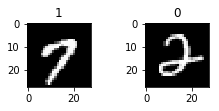

In [4]:
# view image

for i in range(1,3):
    plt.subplot(330 + (i+1))
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i]);

In [5]:
# pre-process data

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (12223, 28, 28, 1)
12223 train samples
2060 test samples


#### Build and compile convnet
I have experimented with different neural net architecture. In general, convnet works better with the problem of digit recognizer 
compared to MLP or LSTM [code@my github](https://github.com/sukilau/MNIST-deep-learning).
It is also obesrved that putting two layers of convolution immediately after one another tends to produce better model than using single convolution.
Thus we start with the basic model of two-layer convolution and perform GridSearch to further improve its accuracy.

In [ ]:
# define convnet
def create_model(neurons=[4,8,16], kernel_size=[3,3],init_mode='uniform', activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(Conv2D(neurons[0], kernel_size=kernel_size, kernel_initializer=init_mode, activation=activation, input_shape=input_shape))
    model.add(Conv2D(neurons[1], kernel_size=kernel_size, kernel_initializer=init_mode, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(neurons[2],kernel_initializer=init_mode, activation=activation))
    model.add(Dropout(0.5))
    model.add(Dense(2, kernel_initializer=init_mode, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model


# fix random seed for reproducibility
seed = 0
np.random.seed(seed)


# create model
model = KerasClassifier(build_fn=create_model, verbose=1)

# I. GridSearch 

#### Perform GridSearch to improve accuracy of convnet.

Gets 99.757% test accuracy for the best parameter set (trained on all 12223 samples).
    
    {
    'batch_size': 64, 
    'epochs': 20, 
    'kernel_size': [5, 5], 
    'neurons': [32, 64, 128]
    }
    
The above best parameter set is obtained by performing GridSearch on the following grid parameters.
It takes 168 min to complete the GridSearch on a 2.5 GHz Intel Core i5.
   
    {
    'batch_size' : [64,128], 
    'epochs' : [10,20],
    'kernel_size': [[3,3],[5,5]],
    'neurons' : [[32,64,128]]
    }       

#### Define GridSeach parameters, run GridSearch and compute test accuracy

In [ ]:
# define grid search parameters
param_grid  = {               
# uncomment to perform grid search on desired grid parameters
                'batch_size' : [64], 
               'epochs' : [20],
               'kernel_size': [[5,5]],        
#                'batch_size' : [64,128], 
#                'epochs' : [10,20],
#                'kernel_size': [[3,3],[5,5]],        
               'neurons' : [[32,64,128]],     
#                'init_mode' : ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'],
#                'activation' : ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
#                'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
#                'weight_constraint' : [1, 3, 5],
#                'dropout_rate' : [0.25, 0.5, 0.75, 0.9],
             }    

# run grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
# grid_result = grid.fit(x_train, y_train)
grid_result = grid.fit(x_train[:5000], y_train[:5000])  # uncomment to train on a smaller set of examples


# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
    
# test accuracy
print()
print("Test Accuracy", grid_result.score(x_test, y_test))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Epoch 1/20
Epoch 1/20
Epoch 1/20
3333/3333 [==============================] - 62s - loss: 0.1438 - acc: 0.9541      

# II. Visualizing GridSearch results

A closer look to the performance of GridSearch results shows us that the "best model" gives high precision and recall. 
The proportion of missclassfied digits are even for 2s and 7s. It also has a high AUC.


2048/2060 [============================>.] - ETA: 0s

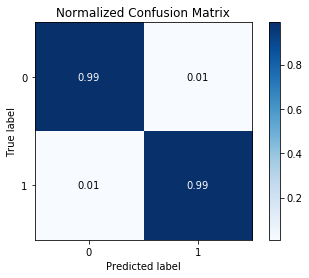

             precision    recall  f1-score   support

          0       0.99      0.99      0.99      1032
          1       0.99      0.99      0.99      1028

avg / total       0.99      0.99      0.99      2060



In [ ]:
# confusion matrix
y_pred = grid_result.predict(x_test)
y_test_1 = np.argmax(y_test, axis=1) # convert one-hot to index
skplt.plot_confusion_matrix(y_test_1, y_pred, normalize=True)
plt.show()

print(classification_report(y_test_1, y_pred))

2048/2060 [============================>.] - ETA: 0s

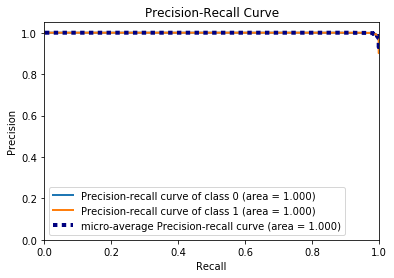

In [ ]:
# precision-recall curve
probas = grid_result.predict_proba(x_test)
skplt.plot_precision_recall_curve(y_test_1, probas)
plt.show()

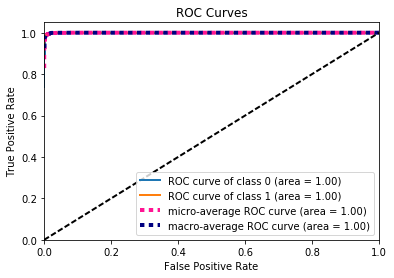

In [ ]:
# ROC curve
skplt.plot_roc_curve(y_test_1, probas)
plt.show()